In [1]:
import numpy as np
from numba import jit,jitclass,float64,int64
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=16,suppress=True)

from naginterfaces.library import machine, roots
eps  = machine.precision()

from numba.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning,NumbaWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)

# Using Anderson Acceleration to speed up fixed-point iterations



##  Accelerating the fixed point solution of sin(x) = x

Type any real number into a calculator and repeatedly press the cosine button. The result eventually converges to about 0.739095 which is the solution of the equation $x = cos(x)$.  This is an example of a fixed-point iteration.  The general case is any computation that looks like this

\begin{align}
x_n{+1} = f(x_n)
\end{align}

which is repeated until a convergence criterion is reached. Such computations arise naturally in many areas of finance, physics and engineering.

We could code the cosine fixed-point computation in Python as follows

In [2]:
def fcos(x):
    """Performs one iteration of the cosine fixed point iteration
    """
    return (np.cos(x))

def fp_driver(x0,func,tol):
    x  = x0 # starting guess
    err = 1000000 # Huge error to start things off
    iterations = 0
    while err > tol: 
        nextx = func(x)
        err = np.sqrt((x - nextx)**2)
        x = nextx
        iterations = iterations +1
    return(iterations,x)

fp_driver(3,fcos,1e-15)

(88, 0.73908513321516034)

Demonstrating that we get convergence to a tolerance of 1e-15 in 88 iterations.  A natural question to ask is 'Can we accelerate the convergence somehow? and the answer is 'Yes, using a technique called [Anderson Acceleration](https://epubs.siam.org/doi/abs/10.1137/10078356X).  Anderson Acceleration has been known in the chemistry community since the 1960s but until relatively recently it wasn't well known in other fields. The [2011 paper by Walker and Ni](https://epubs.siam.org/doi/abs/10.1137/10078356X) describing the technique has been cited over 245 times as of late 2019.

NAG recently introduced two Anderson Acceleration routines into the NAG Library following the success of the technique in the evaluation of nearest correlation matrices (The accelerated nearest correlation matrix routine is implemented in `naginterfaces.library.correg.corrmat_fixed`). Here, we will demonstrate the use of NAG's standard Anderson Acceleration routine `roots.sys_func_aa`

`roots.sys_func_aa` takes the role of `fp_driver` in the code above.  Here's how to use it for the cosine example

In [3]:
def nag_fcos(x):
    """Performs one iteration of the cosine fixed point iteration
    """
    # Note that NAG requires f(x) - x to be returned instead of just f(x)
    return (np.cos(x)-x)

m = 0 # When m=0, Acceleration is turned off so this is identical to running a basic fixed-point calculation
tol = 1e-10
(nag_cos,_) = roots.sys_func_aa(nag_fcos,3.0, tol, eps, m)
(nag_cos)

array([ 0.7390851331723561])

We turn on acceleration by setting `m` to something more than 0. 

In [4]:
(nag_cos,_) = roots.sys_func_aa(nag_fcos,3.0, tol, eps, m=1)
nag_cos

array([ 0.7390851331642223])

Unfortunately, the NAG routine does not return the number of iterations required for convergence so we have no idea what the benefit of acceleration is unless we count them ourselves.  We do this with a helper class which we pass to the `nag_fcos` function

In [5]:
class fpinfo:
    """A class used to get information to/from the NAG routine
    """
    def __init__(self):
        self.iterations = 0
        
def nag_fcos_withdata(x,data):
    """Performs one iteration of the cosine fixed point iteration
    """
    # Note that NAG requires f(x) - x to be returned instead of just f(x)
    data.iterations = data.iterations +1
    return (np.cos(x)-x)

tol = 1e-15
data = fpinfo()
(nag_cos,_) = roots.sys_func_aa(nag_fcos_withdata,3.0, tol, eps, m=0,data=data)
print(f"Solution found was {nag_cos[0]} in {data.iterations} iterations with acceleration switched off")
data = fpinfo()
(nag_cos,_) = roots.sys_func_aa(nag_fcos_withdata,3.0, tol, eps, m=1,data=data)
print(f"Solution found was {nag_cos[0]} in {data.iterations} iterations with acceleration switched on")

Solution found was 0.7390851332151611 in 88 iterations with acceleration switched off
Solution found was 0.7390851332151607 in 10 iterations with acceleration switched on


An almost 9-fold improvement in iteration count simply by switching on acceleration is extremely useful.  We move on to consider a more challenging example of fixed-point iteration.

## Solving the Poisson equation using fixed-point iterations

[Poisson's equation](https://en.wikipedia.org/wiki/Poisson%27s_equation) is an elliptic Partial Differential Equation (PDE) which in 2 dimensions takes the form 

\begin{align}
\nabla^2 u & = f(x,y)\nonumber \\
\left( \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} \right)u(x,y) &= f(x,y)\nonumber
\end{align}

The special case where $f(x)=0$ is referred to as Laplace's equation.  Both Poisson's and Laplace's equations arise in many areas of physics and engineering.

One example which requires the numerical solution of Poisson's equation is finding the steady state of the potential field of 2 parallel lines of electric charge .  One with total charge +1 and the other with total charge -1.  The Dirichlet boundary condition $u(x,y)=0$ is applied at the domain boundary.

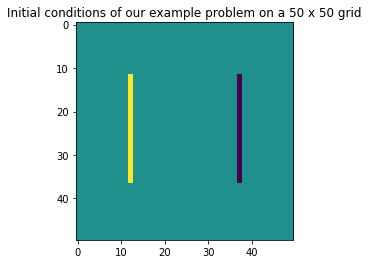

In [6]:
def source(N):
    #  Produces a matrix corresponding to a source term
    #  Want two line sources with total charge of +/- 1 on each line
    # This is our function f(x,y) in the poisson equation
    x0 = np.zeros((N,N))
    h = 1/(N-1)
    source_rows = range((N//4),(3*N//4))
    source_col1 = N//4
    source_col2 = 3*N//4
    
    x0[source_rows,source_col1] = x0[source_rows,source_col1] + 1/(N*0.5*h**2)
    x0[source_rows,source_col2] = x0[source_rows,source_col2] - 1/(N*0.5*h**2)
    return(x0)

def init_problem(N=50):
    # Initialises an N x N problem domain with an initialised source
    x0 = np.zeros((N,N))
    x0 = x0 + source(N)
    return(x0)

x0 = init_problem(50)
plt.imshow(x0);
plt.title('Initial conditions of our example problem on a 50 x 50 grid');

Many introductory courses on the solution of Partial Differential Equations will demonstrate three methods for the solution of systems such as this:

* The Jacobi Method
* The Gauss-Seidel Method
* Successive Over-Relaxation

A paper that discusses these methods in depth using similar notation to this notebook is [Parallel S.O.R. iterative methods](https://www.sciencedirect.com/science/article/pii/S0167819184903806) by D.J. Evans.

We now look at implementing the three solution methods in turn

### The Jacobi Method

Starting from the nth configuration of the discretized grid $u^{n}$, we get the next configuration by applying the following formula to every $(i,j)$th grid point other than the very edges where we apply the boundary conditions.

\begin{align}
u^{n+1}_{j,i} = \frac{1}{4} \left(u^{n}_{j+1,i} +u^{n}_{j-1,i} +u^{n}_{j,i+1} +u^{n}_{j,i-1}  \right)+\frac{h^2}{4}f_{j,i}
\end{align}

An implementation of this iteration in Python is 

In [7]:
@jit
def jacobi(x,source,solverinfo):
    """Performs one iteration of the jacobi method
    
    Arguments:
    x - N x N Matrix containing the previous iteration of the solution
    source - N x N Matrix containing our source function evaluated on the grid
    solverinfo - Takes a solverinfo object to get info in/out of the solver
    """
    N = x.shape[0]
    nextx = np.zeros((N,N))
    h = 1/(N-1)
    # loop over the grid
    # Only iterate over interior points thus keeping the edges untouched and hence enforcing 
    # the boundary condition that x = 0 at the edges.
    for i in range(1,N - 1):
        for j in range(1,N - 1):
            nextx[j,i] = 0.25 * (x[j+1,i] + x[j,i+1] + x[j-1,i] + x[j,i-1]) + 0.25*h**2*source[j,i]
    solverinfo.iterations += 1
    return nextx

Next we need a driver for the Jacobi iteration function.  Something that is general enough to drive subsequent methods of solving our problem.

In [8]:
# This spec is required for Numba jit compilation
spec = [
    ('iterations',int64),
    ('w',float64)
]

@jitclass(spec)
class solverinfo:
    """A class used to get information to/from a solver
    """
    def __init__(self,w = 1):
        self.iterations = 0
        self.w = 1 #Used for SOR and ignored for everything else

def solve_poisson(x,tol,data,method):
    """Solves poisson's equation
    
    x - N x N Matrix containing the initial configuration of the problem space
    tol - Convergence tolerance
    data - A solverinfo object to get arbitrary info in/out of the solver
    method - A function that performs one solution iteration
    """
    N = int(np.sqrt(x.size))
    err = 1 # Big error to start things off with
    while err > tol:    
        nextx = method(x,source(N),data)
        err = np.sqrt(np.sum((x - nextx)**2))
        x = np.copy(nextx)
    return(x)

Finally, we can set up and solve an instance of our problem using the Jacobi method.

Jacobi-Seidel on a 100 by 100 grid
Solution found in 28734 iterations


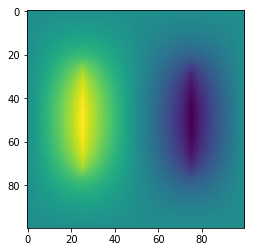

In [9]:
N = 100
u = init_problem(N)
jacobi_info = solverinfo()
tol = 1e-9
jacobi_sol = solve_poisson(u,tol,jacobi_info,jacobi)
print(f"Jacobi-Seidel on a {N} by {N} grid")
print(f"Solution found in {jacobi_info.iterations} iterations")
plt.imshow(jacobi_sol);

Poisson's equation gives us the potential.  For completeness, let's find the electric field by taking the gradient 

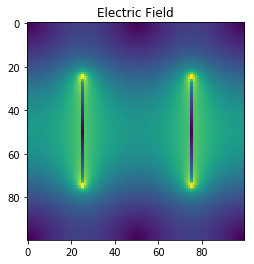

In [10]:
(Ex,Ey) = np.gradient(jacobi_sol)
E = np.sqrt(Ex**2+Ey**2); # Magnitude of Electric field
plt.imshow(E)
plt.title('Electric Field');

28,734 iterations is a lot and one hopes that we can do better with more sophisticated techniques. Fortunately, we can do better and 'more sophisticated' isn't quite as sophisticated as you might fear.

### Gauss-Seidel method

In the Jacobi method, we kept two, independent copies of the solution space.  Each element of the **new** solution is computed from the surrounding elements of the **old** solution.  In Gauss-Seidel we make use of new grid elements as soon as they become available.  That is, when we reach position $(j,i)$ in the grid we have already updated $u_{j-1,i}$ and $u_{j,i-1}$ so we can use those instead of the old values.

\begin{align}
u^{n+1}_{j,i} = \frac{1}{4} \left(u^{n}_{j+1,i} +u^{n+1}_{j-1,i} +u^{n}_{j,i+1} +u^{n+1}_{j,i-1}  \right)+\frac{h^2}{4}f_{j,i}
\end{align}

The Gauss-Seidel iteration, therefore, looks like this

In [11]:
@jit
def gauss_seidel(x,source,solverinfo):
    N = x.shape[0]
    nextx = np.copy(x)
    h = 1/(N-1)
    for i in range(1, N - 1):
        for j in range(1, N - 1):
            nextx[j,i] = 0.25 * (nextx[j+1,i] + nextx[j,i+1] + nextx[j-1,i] + nextx[j,i-1]) + 0.25*h**2*source[j,i]
    solverinfo.iterations += 1
    return nextx

Gauss-Seidel on a 100 by 100 grid
Solution found in 14877 iterations


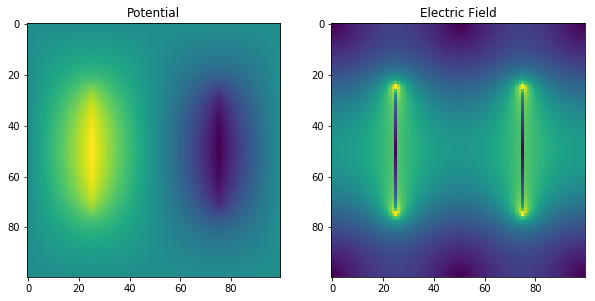

In [12]:
N = 100
u = init_problem(N)
gs_info = solverinfo()
tol = 1e-9
gs_sol = solve_poisson(u,tol,gs_info,gauss_seidel)

print(f"Gauss-Seidel on a {N} by {N} grid")
print(f"Solution found in {gs_info.iterations} iterations")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axes[0].imshow(gs_sol);
axes[0].set_title('Potential')
(Ex,Ey) = np.gradient(gs_sol)
E = np.sqrt(Ex**2+Ey**2); # Magnitude of Electric field
axes[1].imshow(E)
axes[1].set_title('Electric Field');

The number of iterations has almost halved which is a fantastic return on such a small investment.  The standard treatment of this problem has yet another trick up its sleeve with the Successive Over Relaxation Method (SOR) which is an extension of the Gauss-Seidel Method.

### Successive Over Relaxation Method (SOR)

Take the Gauss-Seidel update formula (2) and add and subtract $u_{i,j}^n$ to the right hand side

\begin{align}
u^{n+1}_{j,i} & =  \frac{1}{4} \left(u^{n}_{j+1,i} +u^{n+1}_{j-1,i} +u^{n}_{j,i+1} +u^{n+1}_{j,i-1}  +h^2 f_{j,i} \right) \nonumber \\
& = u_{i,j}^n + \frac{1}{4} \left(u^{n}_{j+1,i} +u^{n+1}_{j-1,i} +u^{n}_{j,i+1} +u^{n+1}_{j,i-1} + h^2 f_{j,i} - 4 u_{i,j}^n \right) \nonumber \\
& = u_{i,j}^n + r_{i,j}
\end{align}

So $r_{i,j}$ is the amount of change of $u_{i,j}$ for one iteration of Gauss_Seidel.  If this amount of change is good, maybe more of the same is better and it turns out that the convergence of Gauss-Seidel can be accelerated by making a larger change as follows 

\begin{align}
u^{n+1}_{j,i} & = u_{i,j}^n + \omega r_{i,j}
\end{align}

where $\omega$ is positive constant called the acceleration factor that in practice lies between 1 and 2.  Note that when $\omega = 1$ the SOR reduces to standard Gauss-Seidel.  

The Python looks like this

In [13]:
@jit
def SOR(x,source,solverinfo):
    N = x.shape[0]
    nextx = np.copy(x)
    h = 1/(N-1)
    w = solverinfo.w
    for i in range(1, N - 1):
        for j in range(1, N - 1):
            new = 0.25 * (nextx[j-1,i] + nextx[j+1,i] + nextx[j,i-1]+ nextx[j,i+1]) + 0.25*h**2*source[j,i]
            nextx[j,i] = nextx[j,i] + w * (new - nextx[j,i])
    solverinfo.iterations += 1
    return nextx

Using this to solve our problem with $\omega=1.94$  we have

SOR on a 100 by 100 grid
Solution found in 486 iterations


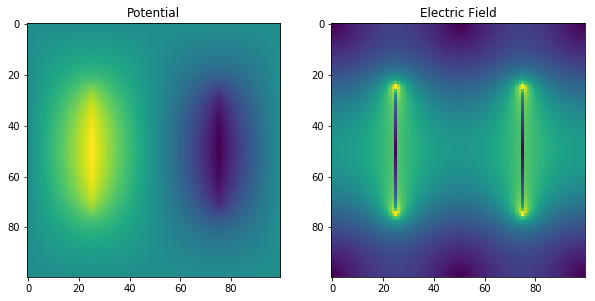

In [14]:
N = 100
u = init_problem(N)
SOR_info = solverinfo()
SOR_info.w = 1.94
tol = 1e-9
SOR_sol = solve_poisson(u,tol,SOR_info,SOR)

print(f"SOR on a {N} by {N} grid")
print(f"Solution found in {SOR_info.iterations} iterations")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axes[0].imshow(SOR_sol);
axes[0].set_title('Potential')
(Ex,Ey) = np.gradient(SOR_sol)
E = np.sqrt(Ex**2+Ey**2); # Magnitude of Electric field
axes[1].imshow(E)
axes[1].set_title('Electric Field');

486 iterations is over 59x faster than our first attempt using the Jacobi method which needed 28,734 iterations to converge.

Choose the SOR $\omega$ parameter badly, however, and you can get performance that's more than 10x slower than when we chose well!  It's still several times faster than Jacobi or Gauss-Seidel however 

SOR on a 100 by 100 grid
Solution found in 5872 iterations


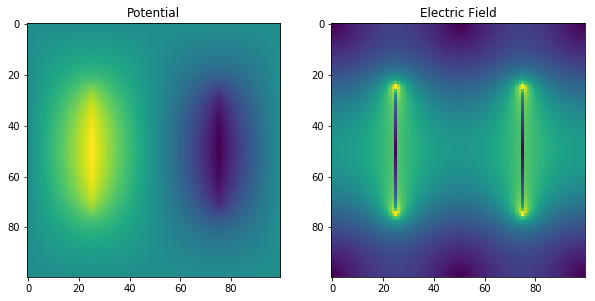

In [15]:
N = 100
u = init_problem(N)
SOR_info = solverinfo()
SOR_info.w = 1.5
tol = 1e-9
SOR_sol = solve_poisson(u,tol,SOR_info,SOR)

print(f"SOR on a {N} by {N} grid")
print(f"Solution found in {SOR_info.iterations} iterations")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axes[0].imshow(SOR_sol);
axes[0].set_title('Potential')
(Ex,Ey) = np.gradient(SOR_sol)
E = np.sqrt(Ex**2+Ey**2); # Magnitude of Electric field
axes[1].imshow(E)
axes[1].set_title('Electric Field');

There are analytic methods available to estimate the optimum $\omega$ but it's often necessary to find it empirically.  The optimum value of $\omega$ depends on both the PDE being solved and on the grid resolution.  More advanced extensions of SOR exist that have even better convergence properties (Chebyshev acceleration for example).  I could also consider parallelisation schemes for these methods such as Red-Black ordering but I need to stop somewhere if I am going to get onto Anderson Acceleration before the deadline of this article!

Before moving, let's look at the number of iterations taken by SOR for this problem as a function of $\omega$

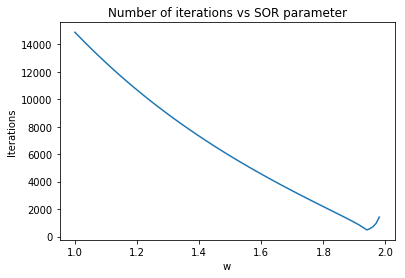

In [16]:
def SOR_iterations(w):
    N = 100
    u = init_problem(N)
    SOR_info = solverinfo()
    SOR_info.w = w
    tol = 1e-9
    SOR_sol = solve_poisson(u,tol,SOR_info,SOR)
    return(SOR_info.iterations)

w = np.arange(1.0,1.99,0.01)
iterations = [SOR_iterations(omega) for omega in w]
plt.plot(w,iterations);
plt.title('Number of iterations vs SOR parameter')
plt.xlabel('w')
plt.ylabel('Iterations');

## Applying NAG's Anderson Acceleration to these methods

### Code adaptations required to call Jacobi iterations from NAG 

I started on this journey because I noted that all of these methods are fixed-point and wondered if NAG's Anderson acceleration would be useful.  Let's go back to Jacobi and recall the definition of each iteration

In [17]:
@jit
def jacobi(x,source,solverinfo):
    """Performs one iteration of the jacobi method
    
    Arguments:
    x - N x N Matrix containing the previous iteration of the solution
    source - N x N Matrix containing our source function evaluated on the grid
    solverinfo - Takes a solverinfo object to get info in/out of the solver
    """
    N = x.shape[0]
    nextx = np.zeros((N,N))
    h = 1/(N-1)
    # loop over the grid
    # Only iterate over interior points thus keeping the edges untouched and hence enforcing 
    # the boundary condition that x = 0 at the edges.
    for i in range(1,N - 1):
        for j in range(1,N - 1):
            nextx[j,i] = 0.25 * (x[j+1,i] + x[j,i+1] + x[j-1,i] + x[j,i-1]) + 0.25*h**2*source[j,i]
    solverinfo.iterations += 1
    return nextx

The NAG routine that performs Anderson acceleration is `roots.sys_func_aa` and the [documentation for it](https://www.nag.co.uk/numeric/py/nagdoc_latest/naginterfaces.library.roots.html) tells us that the function to be solved must have form `fcn(x,data)` where `data` is any arbitrary Python object that can be used to get information in and out of `fcn`.  As such, we are going to need to change the `solverinfo` object so that it also holds the `source` term. 

Two other constraints are going to change the way this function looks:

* The vector $x$ needs to be one-dimensional. As such, we'll need to change the shape to and from the 2D representation we've been using until now.
* We need to return `jacobi(x) - x` instead of `jacobi(x)`

With all of this taken into account, the NAG-ified version of `jacobi` and the supporting `solverinfo` class is 

In [18]:
# This spec is required for Numba jit compilation
spec = [
    ('iterations',int64),
    ('w',float64),
    ('source',float64[:,:])
]

@jitclass(spec)
class NAG_solverinfo:
    """A class used to get information to/from a solver
    """
    def __init__(self,N = 50,w = 1):
        self.iterations = 0
        self.w = 1 #Used for SOR and ignored for everything else
        self.source = np.zeros((N,N))

In [19]:
@jit
def NAG_jacobi(x,solverinfo):
    """Performs one iteration of the jacobi method in the format required by NAG
    
    Arguments:
    x - N x N Matrix containing the previous iteration of the solution
    source - N x N Matrix containing our source function evaluated on the grid
    solverinfo - Takes a solverinfo object to get info in/out of the solver
    """
    N = int(np.sqrt(x.size))
    x.shape = (N,N) # Make x 2D because that's how I think
    nextx = np.zeros((N,N))
    h = 1/(N-1)
    # loop over the grid
    # Only iterate over interior points thus keeping the edges untouched and hence enforcing 
    # the boundary condition that x = 0 at the edges.
    for i in range(1,N - 1):
        for j in range(1,N - 1):
           nextx[j,i] = 0.25 * (x[j+1,i] + x[j,i+1] + x[j-1,i] + x[j,i-1]) + 0.25*h**2*solverinfo.source[j,i]
    solverinfo.iterations += 1
    nextx = nextx - x  # NAG requires this rather than nextx itself
    nextx.shape = N*N  # Make nextx 1D since that's what NAG needs
    return nextx

We can now call the NAG Anderson Acceleration routine.  If we set `m=0`, no acceleration is applied and the routine simply acts as a driver for our fixed point iterations.  We should get exactly the same behavior as our original code.  We can see that this is the case, right down to the 28,734 iterations required for the Jacobi method to solve.

This gives us confidence that our code changes haven't broken anything with the simulation.

In [20]:
N = 100
x0 = init_problem(N)
x0.shape = N*N
NAG_jacobi_info = NAG_solverinfo()
nag_source = source(N)
NAG_jacobi_info.source = nag_source 
tol = 1e-9
m = 0
(NAG_jacobi_sol,fvec) = roots.sys_func_aa(NAG_jacobi, x0, tol, eps, m,data=NAG_jacobi_info)

NAG driven Jacobi on a 100 by 100 grid with no acceleration
Solution found in 28734 iterations


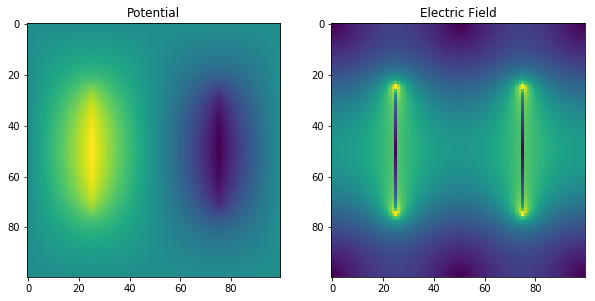

In [21]:
print(f"NAG driven Jacobi on a {N} by {N} grid with no acceleration")
print(f"Solution found in {NAG_jacobi_info.iterations} iterations")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
NAG_jacobi_sol.shape = (N,N)
axes[0].imshow(NAG_jacobi_sol);
axes[0].set_title('Potential')
(Ex,Ey) = np.gradient(NAG_jacobi_sol)
E = np.sqrt(Ex**2+Ey**2); # Magnitude of Electric field
axes[1].imshow(E)
axes[1].set_title('Electric Field');

Set `m=4` as suggested in the NAG documentation and convergence is much faster.  In fact, it's almost 3x faster than Gauss Seidel but we didn't need to change the mathematics in the Jacobi iteration at all.  As such, we can think of Anderson Acceleration as a black-box accelerator for at least some types of fixed point iteration. 

In [22]:
N = 100
x0 = init_problem(N)
x0.shape = N*N
NAG_jacobi_info = NAG_solverinfo()
NAG_jacobi_info.source = source(N)
tol = 1e-9
m=4
(NAG_jacobi_sol,fvec) = roots.sys_func_aa(NAG_jacobi, x0, tol, eps, m,data=NAG_jacobi_info)
print(f"Anderson Accelerated Jacobi with m={m} on a {N} by {N} grid")
print(f"Solution found in {NAG_jacobi_info.iterations} iterations")

Anderson Accelerated Jacobi with m=4 on a 100 by 100 grid
Solution found in 5437 iterations


### Anderson Acceleration and Gauss-Seidel

Next we combine Anderson Acceleration with the Gauss-Seidel method 

In [23]:
@jit
def NAG_gauss_seidel(x,solverinfo):
    N = int(np.sqrt(x.size))
    x.shape = (N,N) # Make x 2D because that's how I think
    nextx = np.copy(x)
    h = 1/(N-1)
    for i in range(1, N - 1):
        for j in range(1, N - 1):
            nextx[j,i] = 0.25 * (nextx[j+1,i] + nextx[j,i+1] + nextx[j-1,i] + nextx[j,i-1]) + 0.25*h**2*solverinfo.source[j,i]
    solverinfo.iterations += 1
    nextx = nextx - x  # NAG requires this rather than nextx itself
    nextx.shape = N*N  # Make nextx 1D since that's what NAG needs
    return nextx

In [24]:
# Define and run the simulation using Gauss-Seidel and NAG Anderson Acceleration

N = 100
x0 = init_problem(N)
x0.shape = N*N
NAG_gs_info = NAG_solverinfo()
NAG_gs_info.source = source(N)
tol = 1e-9
m = 4
(NAG_jacobi_sol,fvec) = roots.sys_func_aa(NAG_gauss_seidel, x0, tol, eps, m,data=NAG_gs_info)
print(f"Anderson Accelerated Gauss-Seidel with m={m} on a {N} by {N} grid")
print(f"Solution found in {NAG_gs_info.iterations} iterations")

Anderson Accelerated Gauss-Seidel with m=4 on a 100 by 100 grid
Solution found in 540 iterations


With the standard choice of `m=4` we are doing almost as well as the best value of $\omega$ we could find for SOR.  Switching to `m=7` and we do even better than SOR.

In [25]:
# Define and run the simulation using Gauss-Seidel and NAG Anderson Acceleration

N = 100
x0 = init_problem(N)
x0.shape = N*N
NAG_gs_info = NAG_solverinfo()
NAG_gs_info.source = source(N)
tol = 1e-9
m = 7
(NAG_jacobi_sol,fvec) = roots.sys_func_aa(NAG_gauss_seidel, x0, tol, eps, m,data=NAG_gs_info)
print(f"Anderson Accelerated Gauss-Seidel with m={m} on a {N} by {N} grid")
print(f"Solution found in {NAG_gs_info.iterations} iterations")

Anderson Accelerated Gauss-Seidel with m=7 on a 100 by 100 grid
Solution found in 466 iterations


Once again, we find ourselves needing to find the perfect aceleration parameter.  Let's see how the number of iterations varies with m.

In [26]:
def find_best_m(m):
    N = 100
    x0 = init_problem(N)
    x0.shape = N*N
    NAG_gs_info = NAG_solverinfo()
    NAG_gs_info.source = source(N)
    tol = 1e-9
    (NAG_jacobi_sol,fvec) = roots.sys_func_aa(NAG_gauss_seidel, x0, tol, eps, m,data=NAG_gs_info)
    return(NAG_gs_info.iterations)

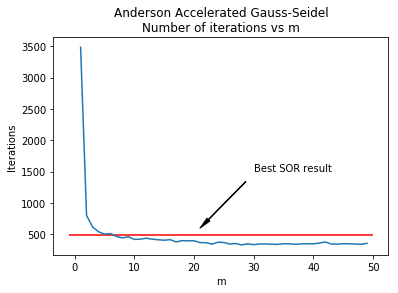

In [27]:
mlist = np.arange(1,50,1)
iterations = [find_best_m(m) for m in mlist]
plt.plot(mlist,iterations);
plt.hlines(486,-1,50,'r')
plt.title('Anderson Accelerated Gauss-Seidel\nNumber of iterations vs m')
plt.xlabel('m')
plt.ylabel('Iterations');

label_x = 30
label_y = 1500
arrow_x = 20
arrow_y = 500

arrow_properties = dict(
    facecolor="black", width=0.5,
    headwidth=4, shrink=0.1)

plt.annotate(
    "Best SOR result", xy=(arrow_x, arrow_y),
    xytext=(label_x, label_y),
    arrowprops=arrow_properties);

The situation with the Anderson Acceleration parameter is rather better than the SOR parameter in that, for this simulation at least, we **always** do better than the best SOR result (486 iterations) for all `m>6` with the very best result being 330 iterations at `m=28`.  Furthermore, once you get past `m=10` for this simulation, the curve is pretty flat meaning that we are not being excessively punished for a bad choice of `m.

## Combined SOR and Anderson Acceleration

The next natural question to ask is 'could we combine both acceleration methods and do even better than anything seen so far'?

In [28]:
@jit
def NAG_SOR(x,solverinfo):
    N = int(np.sqrt(x.size))
    x.shape = (N,N) # Make x 2D because that's how I think
    nextx = np.copy(x)
    h = 1/(N-1)
    w = solverinfo.w
    for i in range(1, N - 1):
        for j in range(1, N - 1):
            new = 0.25 * (nextx[j-1,i] + nextx[j+1,i] + nextx[j,i-1]+ nextx[j,i+1]) + 0.25*h**2*solverinfo.source[j,i]
            nextx[j,i] = nextx[j,i] + w * (new - nextx[j,i])
    solverinfo.iterations += 1
    nextx = nextx - x  # NAG requires this rather than nextx itself
    nextx.shape = N*N  # Make nextx 1D since that's what NAG needs
    return nextx

In [29]:
# Define and run the simulation using SOR and NAG Anderson Acceleration
N = 100
x0 = init_problem(N)
x0.shape = N*N
NAG_SOR_info = NAG_solverinfo()
NAG_SOR_info.w = 1.94
NAG_SOR_info.source = source(N)
tol = 1e-9
m = 28
(NAG_SOR_sol,fvec) = roots.sys_func_aa(NAG_SOR, x0, tol, eps, m,data=NAG_SOR_info)
print(f"Anderson Accelerated SOR with m={m} and w={NAG_SOR_info.w} on a {N} by {N} grid")
print(f"Solution found in {NAG_SOR_info.iterations} iterations")

Anderson Accelerated SOR with m=28 and w=1.94 on a 100 by 100 grid
Solution found in 442 iterations


We see that using the best values of m and $\omega$  found so far gave us a result worse than using either of them independently.  Does there exist any combination that does better than either SOR or Gauss-Seidel with Anderson independently?

Scanning over the range of m and w, we have the following results

In [31]:
def find_best_mw(m,w):
    N = 100
    x0 = init_problem(N)
    x0.shape = N*N
    NAG_SOR_info = NAG_solverinfo()
    NAG_SOR_info.source = source(N)
    NAG_SOR_info.w = w
    tol = 1e-9
    (NAG_SOR_sol,fvec) = roots.sys_func_aa(NAG_SOR, x0, tol, eps, m,data=NAG_SOR_info)
    return(NAG_SOR_info.iterations)

In [32]:
#This will take a long time!
wlist = np.arange(1.01,1.99,0.01)
mlist = np.arange(5,60,1)
mw_list = [(m,w,find_best_mw(m,w)) for m in mlist for w in wlist ]

C:\Users\michael.croucher\AppData\Local\Continuum\anaconda3\envs\NAGPythonRelease\lib\site-packages\ipykernel_launcher.py:9: NagAlgorithmicWarning: (NAG Python function naginterfaces.base.roots.sys_func_aa, code 8:8,99992)
** The iteration is not making good progress.
** This failure exit may indicate that the system does not have a zero, or
** that the solution is very close to the origin.
** Rerunning sys_func_aa from a different starting point may avoid
** the region of difficulty.
  if __name__ == '__main__':


In [33]:
#Best 5
mw_list.sort(key=lambda x:x[2])
mw_list[0:5]

[(26, 1.9800000000000009, 292),
 (36, 1.6000000000000005, 294),
 (21, 1.6100000000000005, 298),
 (20, 1.6200000000000006, 300),
 (22, 1.5900000000000005, 300)]

In [34]:
#Worst 10
mw_list.sort(key=lambda x:x[2],reverse=True)
mw_list[0:5]

[(5, 1.9800000000000009, 1509),
 (6, 1.9800000000000009, 1482),
 (7, 1.9800000000000009, 1456),
 (8, 1.9800000000000009, 1323),
 (11, 1.9800000000000009, 1313)]

By using SOR and Anderson Acceleration we **can** so better than pure SOR or Anderson Accelerated Gauss-Seidel but it seems to be difficult to choose the best combination of combined $\omega$ and $m$.  An SOR $\omega$ of 1.98 features in the best and the worst results found.

# Conclusions

Anderson Acceleration is a general method for accelerating many fixed point iteration methods. We have shown that it can be used to reduce the number of iterations required in the traditional Jacobi and Gauss-Seidel methods for solving Laplace's and Poisson's equations in 2 dimensions. Accelerated Gauss-Seidel beats Successive Over Relaxation (SOR) in many cases.

Anderson Acceleration can be combined with SOR to produce even further levels of acceleration but two different acceleration parameters are then required and it is not clear how to choose the best combination in all cases.